# Compilation of all feature data for the model

In [1]:
import pandas as pd    
import geopandas as gpd
from geopandas.tools import geocode
from shapely.geometry import Point
import numpy as np
import shapely
from shapely import speedups
speedups.enabled
import matplotlib 
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 20})

## Zipcode boundary download

In [2]:
# Zip code boundaries
zipcodes_url = 'https://opendata.arcgis.com/datasets/83fc2e72903343aabff6de8cb445b81c_2.geojson'
zipcodes = gpd.read_file(zipcodes_url)
zipcodes_columns = ['ZIPCODE', 'SHAPE_Area', 'geometry']
zipcodes_cleaned = zipcodes.loc[:,zipcodes_columns]
zipcodes_cleaned['ZIPCODE'] = zipcodes_cleaned['ZIPCODE'].astype(int)

In [3]:
zipcodes_cleaned.head()

,ZIPCODE,SHAPE_Area,geometry
0,98031,2.280129e+08,"POLYGON ((-122.21842 47.43750, -122.21896 47.4..."
1,98032,4.826754e+08,"MULTIPOLYGON (((-122.24187 47.44122, -122.2436..."
2,98033,2.566747e+08,"POLYGON ((-122.20571 47.65170, -122.20571 47.6..."
3,98034,2.725072e+08,"POLYGON ((-122.17551 47.73706, -122.17551 47.7..."
4,98030,2.000954e+08,"POLYGON ((-122.16746 47.38549, -122.16746 47.3..."


## Census Boundary Download

In [7]:
# Census tract boundaries
census_url = 'https://opendata.arcgis.com/datasets/de58dc3e1efc49b782ab357e044ea20c_9.geojson'
census_bounds = gpd.read_file(census_url)
census_columns = ['NAME10', 'SHAPE_Area', 'geometry']
census_bounds_cleaned = census_bounds.loc[:,census_columns]
census_bounds_cleaned['NAME10'] = census_bounds_cleaned['NAME10'].astype(float)

We also need to get the centroids of the census tract data for the population data set.

<ipython-input-14-1a33f3dc1daf>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  census_cent['geometry'] = census_cent['geometry'].centroid


<AxesSubplot:>

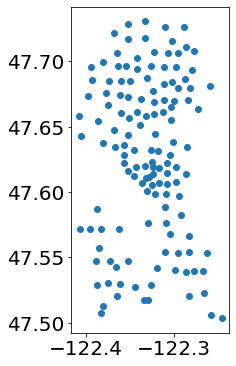

In [14]:
#Centroid points of census tracts
census_cent = census_bounds_cleaned

census_cent['geometry'] = census_cent['geometry'].centroid
census_cent.plot(figsize=(15,6))

## Narrow zip codes by census tracts
We do this to limit the zip code areas to only Seattle.

In [8]:
# Zip codes joined with census tracts
zips = gpd.sjoin(zipcodes_cleaned, census_bounds_cleaned, op='intersects')
zips_columns = ['ZIPCODE', 'NAME10', 'SHAPE_Area_left', 'geometry']
zips = zips[zips_columns]

In [9]:
zips.rename(columns = {'SHAPE_Area_left': 'SHAPE_Area'})

,ZIPCODE,NAME10,SHAPE_Area,geometry
34,98101,74.02,1.470012e+07,"POLYGON ((-122.32785 47.61850, -122.32791 47.6..."
35,98102,74.02,4.322189e+07,"POLYGON ((-122.31232 47.64705, -122.31321 47.6..."
77,98122,74.02,6.454818e+07,"POLYGON ((-122.32272 47.61931, -122.32282 47.6..."
34,98101,74.01,1.470012e+07,"POLYGON ((-122.32785 47.61850, -122.32791 47.6..."
35,98102,74.01,4.322189e+07,"POLYGON ((-122.31232 47.64705, -122.31321 47.6..."
...,...,...,...,...
90,98177,16.00,1.596729e+08,"POLYGON ((-122.35904 47.77776, -122.35937 47.7..."
90,98177,5.00,1.596729e+08,"POLYGON ((-122.35904 47.77776, -122.35937 47.7..."
91,98178,260.01,1.353505e+08,"POLYGON ((-122.21902 47.50057, -122.21914 47.5..."
99,98199,56.00,1.145346e+08,"MULTIPOLYGON (((-122.40912 47.67160, -122.4093..."


In [12]:
zips_sea = zips.dissolve(by='ZIPCODE')

In [13]:
len(zips_sea)

32

## Bike Rack data

In [39]:
# Loads bike rack data
racks_url = 'https://opendata.arcgis.com/datasets/f86c29ce743e47819e588c3d643ceb63_0.geojson'
r = gpd.read_file(racks_url)

In [54]:
# Creates a dataframe "racks" of bike rack locations and years installed
racks = r[['INSTALL_DATE', 'RACK_CAPACITY', 'geometry']]
racks = racks[racks.INSTALL_DATE.notnull()]
racks['Year'] = pd.DatetimeIndex(racks['INSTALL_DATE']).year
racks = racks.drop(columns='INSTALL_DATE')

In [128]:
racks.head()

,RACK_CAPACITY,geometry,Year
4,12,POINT (-122.31426 47.65824),2019
5,2,POINT (-122.33076 47.60690),2015
6,8,POINT (-122.33386 47.60394),2014
7,2,POINT (-122.34242 47.63076),2012
8,2,POINT (-122.31218 47.66483),2016


In [129]:
racks_half_filtered = racks[racks['Year'] >= 2007]

In [130]:
racks_filtered = racks_half_filtered[racks_half_filtered['Year'] <= 2018]

In [132]:
racks_filtered.head()

,RACK_CAPACITY,geometry,Year
5,2,POINT (-122.33076 47.60690),2015
6,8,POINT (-122.33386 47.60394),2014
7,2,POINT (-122.34242 47.63076),2012
8,2,POINT (-122.31218 47.66483),2016
10,2,POINT (-122.34957 47.65041),2008


In [133]:
racks_zips = gpd.sjoin(zips_sea, racks_filtered, op='contains')

In [134]:
racks_zips.reset_index(inplace=True)

In [135]:
racks_zips.head()

,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,RACK_CAPACITY,Year
0,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,2529,2,2016
1,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,2457,2,2014
2,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,2257,8,2014
3,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,630,2,2010
4,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,1934,14,2013


In [136]:
len(racks_zips)

1596

In [137]:
zips_racks = racks_zips.dissolve(by=["Year", "ZIPCODE"], aggfunc=sum)

In [138]:
zips_racks.reset_index(inplace=True)

In [139]:
zips_racks.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,RACK_CAPACITY
0,2007,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",592.16,1.176010e+08,15566,16
1,2007,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",148.04,8.644377e+07,4465,4
2,2007,98103,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",360.00,1.152067e+09,17688,20
3,2007,98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",252.00,6.326191e+07,4806,10
4,2007,98105,"MULTIPOLYGON (((-122.32859 47.66646, -122.3285...",615.00,1.455532e+09,35219,34


## Bike Lanes

In [26]:
#Bike lanes and walkways
df_SND = gpd.read_file('Street_Network_Database_SND.geojson')

In [68]:
lane_columns = ['SEGMENT_TY', 'SNDSEG_UPD', 'SHAPE_Leng', 'geometry']
bike_lane = df_SND[lane_columns]

In [69]:
bike_lane['Year'] = pd.DatetimeIndex(bike_lane['SNDSEG_UPD']).year
bike_lane.drop(columns='SNDSEG_UPD')

/home/spristash3/anaconda3/envs/python-gis/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,SEGMENT_TY,SHAPE_Leng,geometry,Year
0,1,291.426335,"LINESTRING (-122.32286 47.52981, -122.32287 47...",2007
1,1,431.467882,"LINESTRING (-122.32400 47.61848, -122.32401 47...",2007
2,1,162.446146,"LINESTRING (-122.29191 47.76490, -122.29126 47...",2004
3,6,79.522621,"LINESTRING (-122.30780 47.61410, -122.30748 47...",2004
4,1,643.835648,"LINESTRING (-122.38213 47.67455, -122.38474 47...",2012
...,...,...,...,...
34201,1,305.488287,"LINESTRING (-122.31417 47.67145, -122.31410 47...",2021
34202,1,97.898257,"LINESTRING (-122.34210 47.60772, -122.34250 47...",2021
34203,1,421.473404,"LINESTRING (-122.32610 47.46873, -122.32440 47...",2021
34204,1,238.008808,"LINESTRING (-122.32440 47.46874, -122.32344 47...",2021


In [153]:
bike_half_filtered = bike_lane[bike_lane['Year'] >= 2007]

In [154]:
bike_filtered = bike_half_filtered[bike_half_filtered['Year'] <= 2018]

In [155]:
bike_lanes = bike_filtered[bike_filtered['SEGMENT_TY']==6]

In [156]:
# # Joins zip codes with bike racks
zips_bikelane = gpd.sjoin(zips_sea, bike_lanes, op='intersects')

In [157]:
zips_bikelane.reset_index(inplace=True)

In [158]:
zips_bikelane.head()

,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,SEGMENT_TY,SNDSEG_UPD,SHAPE_Leng,Year
0,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,33054,6,2018-10-10,348.181761,2018
1,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,19520,6,2011-02-24,37.022380,2011
2,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",74.02,4.322189e+07,19360,6,2011-02-24,48.332055,2011
3,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",74.02,4.322189e+07,19618,6,2011-02-24,155.004470,2011
4,98103,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",45.00,1.440083e+08,29471,6,2015-10-16,175.772258,2015


In [159]:
zips_lanes = zips_bikelane.dissolve(by=['Year', 'ZIPCODE'], aggfunc=sum)

In [160]:
zips_lanes.reset_index(inplace=True)

In [161]:
zips_lanes.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,SEGMENT_TY,SHAPE_Leng
0,2007,98109,"POLYGON ((-122.35819 47.64769, -122.35810 47.6...",148.02,1.327115e+08,35860,12,333.346820
1,2007,98112,"MULTIPOLYGON (((-122.31863 47.63069, -122.3186...",65.00,8.818645e+07,760,6,298.814978
2,2007,98118,"MULTIPOLYGON (((-122.29280 47.53008, -122.2924...",234.00,3.414372e+08,31739,12,462.728981
3,2007,98122,"POLYGON ((-122.32845 47.61473, -122.32802 47.6...",74.02,6.454818e+07,9308,6,179.593800
4,2008,98109,"POLYGON ((-122.35819 47.64769, -122.35810 47.6...",74.01,6.635577e+07,18299,6,240.982966


## Walkways

Note: the walkways data is from the same dataset as the bike lanes, so we just need to select the proper category.

In [164]:
walks = bike_filtered[bike_filtered['SEGMENT_TY']==5]

In [165]:
walks.head()

,SEGMENT_TY,SNDSEG_UPD,SHAPE_Leng,geometry,Year
17992,5,2008-04-09,465.983637,"LINESTRING (-122.38645 47.54191, -122.38646 47...",2008
18578,5,2018-08-07,205.825219,"LINESTRING (-122.39685 47.56481, -122.39687 47...",2018
18579,5,2018-08-07,477.994666,"LINESTRING (-122.39689 47.56250, -122.39690 47...",2018
26160,5,2018-08-07,256.086521,"LINESTRING (-122.37126 47.57126, -122.37129 47...",2018
26161,5,2018-08-07,231.884838,"LINESTRING (-122.37137 47.56987, -122.37139 47...",2018


In [166]:
# # Joins zip codes with bike racks
zips_walks = gpd.sjoin(zips_sea, walks, op='intersects')

In [167]:
zips_walks.reset_index(inplace=True)

In [168]:
zips_walks.head()

,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,SEGMENT_TY,SNDSEG_UPD,SHAPE_Leng,Year
0,98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",84.00,2.108730e+07,32045,5,2018-06-12,305.995367,2018
1,98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",84.00,2.108730e+07,32050,5,2018-06-12,306.366108,2018
2,98105,"MULTIPOLYGON (((-122.32860 47.66653, -122.3286...",41.00,9.703543e+07,27584,5,2018-07-20,219.509921,2018
3,98105,"MULTIPOLYGON (((-122.32860 47.66653, -122.3286...",41.00,9.703543e+07,27580,5,2018-07-20,689.724771,2018
4,98106,"POLYGON ((-122.37057 47.56924, -122.37056 47.5...",114.02,1.482014e+08,27746,5,2015-03-27,666.636653,2015


In [169]:
zips_walkways = zips_walks.dissolve(by=['Year', 'ZIPCODE'], aggfunc=sum)

In [170]:
zips_walkways.reset_index(inplace=True)

In [171]:
zips_walkways.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,SEGMENT_TY,SHAPE_Leng
0,2008,98136,"POLYGON ((-122.40199 47.55763, -122.40137 47.5...",106.00,6.319544e+07,17992,5,465.983637
1,2014,98117,"POLYGON ((-122.40987 47.67665, -122.40833 47.6...",35.00,1.073120e+08,27631,5,665.738612
2,2015,98106,"POLYGON ((-122.37057 47.56924, -122.37056 47.5...",114.02,1.482014e+08,27746,5,666.636653
3,2015,98121,"POLYGON ((-122.36110 47.61854, -122.36095 47.6...",81.00,1.225219e+07,28226,5,729.415860
4,2016,98119,"POLYGON ((-122.38986 47.63197, -122.38976 47.6...",80.01,7.607224e+07,29983,5,863.086371


## Populations

The population data is sorted by census tract, so to avoid double counting populations we will do a spatial join by centroids instead of across the two polygons.

In [79]:
pop_url_2010 = 'https://gisrevprxy.seattle.gov/arcgis/rest/services/CENSUS_EXT/CENSUS_2010_BASICS/MapServer/15/query?where=1%3D1&outFields=SHAPE,GEOID10,NAME10,ACRES_TOTAL,Total_Population,OBJECTID&outSR=4326&f=json'

In [80]:
pop_2010 = gpd.read_file(pop_url_2010)
pop_2010['geometry'] = census_cent['geometry']
pop_2010.head()

,GEOID10,NAME10,ACRES_TOTAL,Total_Population,OBJECTID,geometry
0,53033002500,25,243.219083,2802.0,1,POINT (-122.30228 47.68390)
1,53033002600,26,307.584420,4660.0,2,POINT (-122.31193 47.68275)
2,53033005600,56,737.511727,6382.0,3,POINT (-122.40574 47.64278)
3,53033006800,68,177.438771,2834.0,4,POINT (-122.35646 47.63603)
4,53033006000,60,324.567432,5150.0,5,POINT (-122.35286 47.64393)


In [87]:
pop_zips = gpd.sjoin(zips, pop_2010, op='contains')

In [88]:
pop_zips.head()

,geometry,NAME10_left,SHAPE_Area_left,index_right,GEOID10,NAME10_right,ACRES_TOTAL,Total_Population,OBJECTID
ZIPCODE,,,,,,,,,
98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,65,53033008100,81,206.340307,4070.0,66
98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,66,53033008200,82,90.611670,3280.0,67
98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,67,53033008300,83,58.672725,2505.0,68
98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",74.02,4.322189e+07,75,53033007401,74.01,64.092745,4115.0,76
98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",74.02,4.322189e+07,82,53033006100,61,276.424774,4796.0,83


In [89]:
pop_zips.reset_index(inplace=True)

In [90]:
pop_zips = pop_zips[['ZIPCODE','geometry', 'Total_Population']]

In [91]:
pop_zips.head()

,ZIPCODE,geometry,Total_Population
0,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",4070.0
1,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",3280.0
2,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",2505.0
3,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",4115.0
4,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",4796.0


In [101]:
pop_zips_diss = pop_zips.dissolve(by='ZIPCODE', aggfunc='sum')

In [102]:
pop_zips_diss.reset_index(inplace=True)

In [103]:
pop_zips_diss.head()

,ZIPCODE,geometry,Total_Population
0,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",9855.0
1,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",12451.0
2,98103,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",43659.0
3,98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",9674.0
4,98105,"MULTIPOLYGON (((-122.32859 47.66649, -122.3286...",44553.0


In [104]:
total_pop = pop_zips_diss['Total_Population'].sum()
total_pop

608660.0

In [105]:
pop_zips_diss['Pop_fraction'] = pop_zips_diss['Total_Population']/total_pop
pop_zips_diss.head()

,ZIPCODE,geometry,Total_Population,Pop_fraction
0,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",9855.0,0.016191
1,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",12451.0,0.020456
2,98103,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",43659.0,0.071730
3,98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",9674.0,0.015894
4,98105,"MULTIPOLYGON (((-122.32859 47.66649, -122.3286...",44553.0,0.073199


In [106]:
years = list(range(2007, 2019))
years

[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

In [107]:
populations = [585436, 591870, 598539, 608660, 622694, 635928, 653588, 670109, 687386, 709631, 728661, 742235]

In [108]:
pop_by_year = dict(zip(years, populations))
pop_by_year

{2007: 585436,
 2008: 591870,
 2009: 598539,
 2010: 608660,
 2011: 622694,
 2012: 635928,
 2013: 653588,
 2014: 670109,
 2015: 687386,
 2016: 709631,
 2017: 728661,
 2018: 742235}

In [109]:
def est_zip_pop(year, pop_zips_diss, pop_by_year):
    pop_frac = pop_zips_diss['Pop_fraction'].values
    year_pop = pop_by_year.get(year)
    pop_zip_year = pop_zips_diss
    pop_zip_year['Total_Population'] = pop_frac*year_pop
    return pop_zip_year

In [110]:
pop_zip_2007 = est_zip_pop(2007, pop_zips_diss, pop_by_year)
pop_zip_2007.head()

,ZIPCODE,geometry,Total_Population,Pop_fraction
0,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",9478.973121,0.016191
1,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",11975.920277,0.020456
2,98103,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",41993.149417,0.071730
3,98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",9304.879348,0.015894
4,98105,"MULTIPOLYGON (((-122.32859 47.66649, -122.3286...",42853.037998,0.073199


In [111]:
total_pop_2007 = pop_zip_2007['Total_Population'].sum()
total_pop_2007

585435.9999999999

In [112]:
pop_zips_years = gpd.GeoDataFrame()
for year in years:
    pop_zip_year = est_zip_pop(year, pop_zips_diss, pop_by_year)
    pop_zip_year['Year'] = year
    pop_zips_years = pop_zips_years.append(pop_zip_year)


,ZIPCODE,geometry,Total_Population,Pop_fraction,Year
0,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",9478.973121,0.016191,2007
1,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",11975.920277,0.020456,2007
2,98103,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",41993.149417,0.071730,2007
3,98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",9304.879348,0.015894,2007
4,98105,"MULTIPOLYGON (((-122.32859 47.66649, -122.3286...",42853.037998,0.073199,2007


In [122]:
pop_zips_years

,ZIPCODE,geometry,Total_Population,Pop_fraction,Year
0,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",9478.973121,0.016191,2007
1,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",11975.920277,0.020456,2007
2,98103,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",41993.149417,0.071730,2007
3,98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",9304.879348,0.015894,2007
4,98105,"MULTIPOLYGON (((-122.32859 47.66649, -122.3286...",42853.037998,0.073199,2007
...,...,...,...,...,...
23,98146,"POLYGON ((-122.39570 47.51383, -122.39563 47.5...",7353.328706,0.009907,2018
24,98177,"POLYGON ((-122.39486 47.77797, -122.39449 47.7...",9771.512922,0.013165,2018
25,98178,"POLYGON ((-122.28336 47.50997, -122.28255 47.5...",8797.166382,0.011852,2018
26,98195,"POLYGON ((-122.31218 47.65338, -122.31215 47.6...",6958.224477,0.009375,2018


In [113]:
pop_zips_years.tail()

,ZIPCODE,geometry,Total_Population,Pop_fraction,Year
23,98146,"POLYGON ((-122.39570 47.51383, -122.39563 47.5...",7353.328706,0.009907,2018
24,98177,"POLYGON ((-122.39486 47.77797, -122.39449 47.7...",9771.512922,0.013165,2018
25,98178,"POLYGON ((-122.28336 47.50997, -122.28255 47.5...",8797.166382,0.011852,2018
26,98195,"POLYGON ((-122.31218 47.65338, -122.31215 47.6...",6958.224477,0.009375,2018
27,98199,"MULTIPOLYGON (((-122.43581 47.66206, -122.4355...",20884.429090,0.028137,2018


In [172]:
len(pop_zips_years)

336

In [123]:
pop_zips_years = pop_zips_years[['Year', 'ZIPCODE', 'Total_Population', 'Pop_fraction', 'geometry']]

# Merging all features into one dataset for model

In [178]:
a = pd.merge(zips_racks, zips_lanes, zips_walkways, pop_zips_years, on='ZIPCODE')

AttributeError: module 'pandas' has no attribute 'join'

In [179]:
zips_racks_2010 = zips_racks.loc[zips_racks['Year'] == 2010]

In [180]:
zips_racks_2010.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,RACK_CAPACITY
65,2010,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",148.04,2.940025e+07,2082,4
66,2010,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",296.08,1.728875e+08,9258,8
67,2010,98103,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",315.00,1.008058e+09,14057,32
68,2010,98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",84.00,2.108730e+07,30,14
69,2010,98105,"MULTIPOLYGON (((-122.32859 47.66646, -122.3285...",205.00,4.851772e+08,9872,22


In [184]:
zips_lanes_2010 = zips_lanes.loc[zips_lanes['Year'] == 2010]
zips_lanes_2010.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,SEGMENT_TY,SHAPE_Leng
7,2010,98109,"POLYGON ((-122.35819 47.64769, -122.35810 47.6...",74.01,6.635577e+07,18952,6,157.179735


In [185]:
zips_walkways_2010 = zips_walkways.loc[zips_walkways['Year'] == 2010]
zips_walkways_2010.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,SEGMENT_TY,SHAPE_Leng


In [188]:
pops_zips_years_2010 = pop_zips_years.loc[pop_zips_years['Year'] == 2010]
pops_zips_years_2010.head()

,Year,ZIPCODE,Total_Population,Pop_fraction,geometry
0,2010,98101,9855.0,0.016191,"POLYGON ((-122.34598 47.60892, -122.34490 47.6..."
1,2010,98102,12451.0,0.020456,"POLYGON ((-122.33574 47.64203, -122.33108 47.6..."
2,2010,98103,43659.0,0.071730,"POLYGON ((-122.35808 47.69966, -122.35741 47.6..."
3,2010,98104,9674.0,0.015894,"POLYGON ((-122.34105 47.59627, -122.34031 47.5..."
4,2010,98105,44553.0,0.073199,"MULTIPOLYGON (((-122.32859 47.66649, -122.3286..."


In [201]:
len(pops_zips_years_2010)

28

In [204]:
test = pd.concat(zips_racks_2010, pops_zips_years_2010, join='outer')

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "GeoDataFrame"

In [200]:
test.tail()

,Year_x,ZIPCODE,geometry_x,NAME10,SHAPE_Area_left,index_right,RACK_CAPACITY,Year_y,Total_Population,Pop_fraction,geometry_y
12,2010,98121,"POLYGON ((-122.36110 47.61854, -122.36095 47.6...",729.00,1.102697e+08,14620,18,2010,8601.0,0.014131,"POLYGON ((-122.36110 47.61854, -122.36095 47.6..."
13,2010,98122,"POLYGON ((-122.32845 47.61473, -122.32802 47.6...",1184.32,1.032771e+09,38293,50,2010,37656.0,0.061867,"POLYGON ((-122.32845 47.61473, -122.32802 47.6..."
14,2010,98125,"POLYGON ((-122.33146 47.71591, -122.32924 47.7...",19.00,1.498538e+08,1147,2,2010,33879.0,0.055662,"POLYGON ((-122.33146 47.71591, -122.32924 47.7..."
15,2010,98134,"POLYGON ((-122.35992 47.58242, -122.35991 47.5...",186.00,2.247072e+08,4349,4,2010,2354.0,0.003868,"POLYGON ((-122.35992 47.58242, -122.35991 47.5..."
16,2010,98136,"POLYGON ((-122.40199 47.55763, -122.40137 47.5...",318.00,1.895863e+08,5527,6,2010,20065.0,0.032966,"POLYGON ((-122.40199 47.55763, -122.40137 47.5..."
